In [0]:
class nlp_1:
    # input: 1) doc: dictionary-like documents, the entry's format is (label#id)
    # process: 1, init function: 1) initialize store documents -> 2) build corpus ->
    #       -> 2, transform function 3) transform (bow, 2-gram, 3-gram) -> 4) if tf-idf ->
    #       -> 3, training function 5) training (decision tree, svm, linear regression, mlp, gaussian naive bayes, knn)
    def __init__(self, doc, shuffle=1):
        # shuffle part
        if shuffle == 0:
            self.doc = doc
        else:
            from random import shuffle
            shuffled_keys = list(doc.keys())
            shuffle(shuffled_keys)
            shuffled_documents = dict()
            for entry in shuffled_keys:
                shuffled_documents.update({entry: doc[entry]})
            self.doc = shuffled_documents

        # prepare_corpus and label_size
        corpus = []
        label_set = set()
        for entry in self.doc:
            string = ''
            label_set.add(int(entry.split('#')[0]))
            for words in self.doc[entry]:
                string += words + ' '
            self.doc[entry] = string
            corpus.append(string)
        self.corpus = corpus
        self.label = list(label_set)

        # transform vec
        self.vec = None

        # input_x; input_y;
        self.x = None
        self.y = None

        # transform name
        self.trans_name = None

        # module for train and predict
        self.module = None
        self.module_name = None

        # scores
        self.scores = None

    def transform(self, type='bow', tf_idf=True):

        import numpy as np
        from sklearn.feature_extraction.text import CountVectorizer

        # transform type
        if type == 'bow':  # must be type == 'bow' or type == 'tf-idf', cannot use type == 'bow' or 'tf-idf'
            vec = CountVectorizer()
            tran = vec.fit_transform(self.corpus)
            # ???

        elif type == '3-gram':
            vec = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b', min_df=1)
            tran = vec.fit_transform(self.corpus)

        elif type == '2-gram':
            vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b', min_df=1)
            tran = vec.fit_transform(self.corpus)

        else:
            pass

        self.vec = vec

        # if tf-idf and build input_x
        if tf_idf == True:
            from sklearn.feature_extraction.text import TfidfTransformer
            vec_tf_idf = TfidfTransformer(smooth_idf=False)
            self.x = vec_tf_idf.fit_transform(tran).toarray()

        else:
            self.x = tran.toarray()

        self.y = np.zeros(self.x.shape[0])  # build input_y

        i = 0
        for entry in self.doc:
            self.y[i] = entry.split('#')[0]
            i += 1
        print(str(type) + ' is finished whose length is ' + str(self.x.shape[1]))

        self.trans_name = str(type) + '#' + str(tf_idf)

        return self

    # select and configure the learning module
    # input: module type
    # output: self
    # self update: self.module
    def configuration(self, type='decision tree'):

        from sklearn.model_selection import cross_val_score

        if type == 'decision tree':
            from sklearn.tree import DecisionTreeClassifier
            module_conf = DecisionTreeClassifier()

        elif type == 'svm':
            from sklearn.svm import SVC
            module_conf = SVC(C=50)

        elif type == 'linear regression':
            from sklearn.linear_model import LinearRegression
            module_conf = LinearRegression()

        elif type == 'mlp':
            from sklearn.neural_network import MLPClassifier
            module_conf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000,))

        elif type == 'gaussian naive bayes':
            from sklearn.naive_bayes import GaussianNB
            module_conf = GaussianNB()

        elif type == 'knn':
            from sklearn.neighbors import KNeighborsClassifier
            module_conf = KNeighborsClassifier(n_neighbors=3)

        self.module = module_conf
        self.module_name = type

        return self

    # train the learning module, configuration must be used in advance
    # prepare: self.module
    # output: self
    # self update: none
    def training(self, X_train, y_train):

        self.module.fit(X_train, y_train)

        return self

    # calculate scores, configuration must be used in advance
    # prepare: self.module
    # output: self
    # self update: self.scores
    def calscores(self):

        from sklearn.model_selection import cross_val_score

        self.scores = cross_val_score(self.module, self.x, self.y, cv=10)

        return self

    def confusion_matrix_chart(self, test_part=0.1, state=0):

        from sklearn.model_selection import train_test_split
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns

        # confusion_matrix
        X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size = test_part, random_state = state)
        self.training(X_train, y_train)
        y_pred = self.module.predict(X_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        plt.subplots(figsize=(len(self.label), len(self.label)))
        sns.heatmap(conf_mat, annot=True, fmt='d',
                    xticklabels=self.label, yticklabels=self.label)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(self.module_name)
        plt.show()

        # confusion_chart
        key_raw = self.vec.get_feature_names()
        error_dict = dict()
        for x in range(len(self.label)):
            for y in range(len(self.label)):
                if x != y and conf_mat[x][y] >= 5:
                    actual_label = self.label[x]
                    predict_label = self.label[y]
                    for line_index in range(len(y_pred)):
                        if y_test[line_index] == actual_label and y_pred[line_index] == predict_label:
                            print('actual:' + str(actual_label) + 'prediction:' + str(predict_label) + 'line:' + str(line_index))
                            x_test_error = X_test[line_index]
                            for col_index in range(len(key_raw)):
                                if x_test_error[col_index] > 1:
                                    print(str(key_raw[col_index]) + ': ' + str(x_test_error[col_index]))

        return self

In [0]:
def main():
    ########### PREPARE & PREPROCESS ################
    # get names of all gutenberg's books
    import nltk
    nltk.download('gutenberg')
    txt_list = ['austen-emma', 'bible-kjv', 'blake-poems', 'bryant-stories', 'burgess-busterbrown',
            'carroll-alice', 'chesterton-ball', 'edgeworth-parents', 'melville-moby_dick',
            'milton-paradise', 'shakespeare-hamlet', 'whitman-leaves']
    author_label = dict()
    author_label = {'austen' : 0, 'bible' : 1, 'blake': 3, 'bryant': 4, 'burgess': 5, 'carroll': 6, 'chesterton': 7,
                  'edgeworth': 8, 'melville': 9, 'milton': 10, 'shakespeare': 11, 'whitman': 12}

    validated_books = 0 # book that contain more than 3000 sentences is validated
    documents = dict() # store documents

    # build 200 * 7 documents and store them in the dictionary named documents
    for txt_name in txt_list:
        if validated_books < 7:
            book_content = nltk.corpus.gutenberg.raw(str(txt_name) + '.txt')
            remove_punc = nltk.tokenize.RegexpTokenizer(r'\w+') # remove punctuation or numbers using tokenizer
            tokenized_words = remove_punc.tokenize(book_content) # detach article into words

            words_len = len(tokenized_words)
            # check if has enough words
            if words_len > (int(30000 / 0.9) + 1):
                print(str(txt_name))
                validated_books += 1
                words_len = int(words_len * 0.9)
                interval = int(words_len / 200) # 200 = number of documents
                for i in range(200):
                    begin_index = int(words_len * 0.1) + interval * i
                    end_index = int(words_len * 0.1) + interval * i + 150
                    documents[str(author_label[txt_name.split("-")[0]]) + '#' + str(i)] = [w.lower() for w in tokenized_words[begin_index : end_index]]
    print('the length of documents ' + str(len(documents)))

    print(documents)

    ########### EXECUTE ################
    train_list = ['decision tree']
    n = nlp_1(documents, shuffle=1)
    n.transform(type='bow', tf_idf=False)

    for tr in train_list:
        n.configuration(type=tr)
        n.confusion_matrix_chart()
        n.calscores()
        print(tr + '\'s scores is ' + str(n.scores) + ' and mean is ' + str(n.scores.mean()))

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
austen-emma
bible-kjv
bryant-stories
chesterton-ball
edgeworth-parents
melville-moby_dick
milton-paradise
the length of documents 1400
{'0#0': ['standing', 'memorial', 'of', 'the', 'beauty', 'of', 'one', 'the', 'skill', 'of', 'the', 'other', 'and', 'the', 'friendship', 'of', 'both', 'with', 'as', 'many', 'other', 'agreeable', 'associations', 'as', 'mr', 'elton', 's', 'very', 'promising', 'attachment', 'was', 'likely', 'to', 'add', 'harriet', 'was', 'to', 'sit', 'again', 'the', 'next', 'day', 'and', 'mr', 'elton', 'just', 'as', 'he', 'ought', 'entreated', 'for', 'the', 'permission', 'of', 'attending', 'and', 'reading', 'to', 'them', 'again', 'by', 'all', 'means', 'we', 'shall', 'be', 'most', 'happy', 'to', 'consider', 'you', 'as', 'one', 'of', 'the', 'party', 'the', 'same', 'civilities', 'and', 'courtesies', 'the', 'same', 'success', 'and', 'satisfaction', 'took', 'place', 'on'

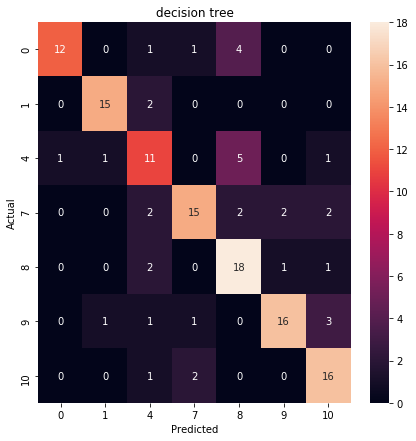

actual:4prediction:8line:20
and: 9
be: 2
carried: 2
cherry: 2
crust: 2
dog: 3
for: 2
from: 2
had: 2
he: 8
in: 2
little: 4
of: 3
poor: 3
pretty: 2
starved: 2
that: 3
the: 11
to: 4
was: 6
woman: 2
actual:4prediction:8line:37
and: 6
brahmin: 8
brother: 4
but: 2
for: 2
him: 2
his: 2
if: 2
in: 2
is: 5
know: 3
let: 2
me: 3
out: 2
said: 3
shut: 2
the: 9
there: 3
tiger: 4
to: 2
up: 3
who: 2
you: 4
actual:4prediction:8line:67
able: 2
and: 6
as: 3
came: 2
go: 2
great: 2
had: 2
he: 12
him: 2
in: 3
it: 3
lion: 4
loose: 2
might: 2
not: 2
of: 3
put: 2
said: 2
stone: 2
tail: 2
tailor: 2
that: 2
the: 14
then: 2
to: 5
under: 2
was: 3
when: 2
workmen: 2
actual:4prediction:8line:112
and: 5
as: 2
father: 3
first: 2
garden: 4
grass: 2
have: 2
her: 3
his: 2
it: 3
margery: 4
new: 2
of: 3
on: 2
said: 2
she: 2
the: 8
then: 2
thing: 2
to: 3
trees: 2
was: 8
when: 2
with: 2
actual:4prediction:8line:135
and: 9
as: 2
away: 2
began: 2
board: 2
bread: 4
could: 2
elsa: 3
fairies: 2
fingers: 3
hands: 2
her: 3
hidden: 2

KeyboardInterrupt: ignored

In [3]:
if __name__ == '__main__':
    main()